<a href="https://colab.research.google.com/github/Kareem-1010/Climate-Disaster-Prediction-ST-GNN-/blob/main/Climate_gnn/notebooks/Climate(ST-GNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')   # allow saving files to your Drive
!nvidia-smi || true
import torch, sys
print("Python:", sys.version.splitlines()[0])
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)

Mounted at /content/drive
Wed Aug 13 13:52:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [2]:
!pip install -q --upgrade pip
!pip install -q xarray netCDF4 rioxarray pandas numpy scipy scikit-learn cdsapi pydap earthengine-api matplotlib cartopy
!pip install -q rasterio rioxarray geopandas shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00


In [3]:
import torch, sys
torch_version = torch.__version__.split('+')[0]
cuda_ver = torch.version.cuda
print("Detected torch:", torch_version, "CUDA:", cuda_ver)

Detected torch: 2.6.0 CUDA: 12.4


In [4]:
import sys, subprocess, importlib, traceback

def run(cmd):
    print("RUN:", " ".join(cmd))
    return subprocess.check_call(cmd)

try:
    import torch
    torch_version = torch.__version__.split('+')[0]
    cuda = torch.version.cuda
    if cuda is None:
        cuda_tag = "cpu"
    else:
        cuda_tag = "cu" + cuda.replace('.', '')
    index_url = f"https://data.pyg.org/whl/torch-{torch_version}+{cuda_tag}.html"
    print("Using PyG index:", index_url)
    run([sys.executable, "-m", "pip", "install", "--quiet", "torch-scatter", "-f", index_url])
    run([sys.executable, "-m", "pip", "install", "--quiet", "torch-sparse", "-f", index_url])
    run([sys.executable, "-m", "pip", "install", "--quiet", "torch-cluster", "-f", index_url])
    run([sys.executable, "-m", "pip", "install", "--quiet", "torch-spline-conv", "-f", index_url])
    run([sys.executable, "-m", "pip", "install", "--quiet", "torch-geometric", "-f", index_url])

    import torch_geometric
    print("torch_geometric version:", torch_geometric.__version__)
except Exception as e:
    print("Automatic PyG install failed. Error:")
    traceback.print_exc()
    print("\nFALLBACK: If PyG install fails, you can either:\n"
          "- Try again after restarting the runtime (sometimes helps)\n"
          "- Use DGL instead for GNN experiments: `pip install dgl` (simpler install)\n"
          "- Or run the notebook on a local machine or Colab Pro where matching wheels exist.")

Using PyG index: https://data.pyg.org/whl/torch-2.6.0+cu124.html
RUN: /usr/bin/python3 -m pip install --quiet torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
RUN: /usr/bin/python3 -m pip install --quiet torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
RUN: /usr/bin/python3 -m pip install --quiet torch-cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
RUN: /usr/bin/python3 -m pip install --quiet torch-spline-conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
RUN: /usr/bin/python3 -m pip install --quiet torch-geometric -f https://data.pyg.org/whl/torch-2.6.0+cu124.html
torch_geometric version: 2.6.1


In [8]:
!pip install --upgrade cdsapi

In [5]:
from google.colab import auth
auth.authenticate_user()

import ee
ee.Authenticate()
ee.Initialize(project='climate-disaster-prediction')
print("Earth Engine initialized:", ee.data._initialized)

Earth Engine initialized: True


In [11]:
cds_uid = "7b91d193-cd72-43c5-91bc-9ddd989f61b0"
cds_api_key = "4a94b0bd-8861-4c55-ade8-11398dfac642"

cds_path = "/root/.cdsapirc"
with open(cds_path, "w") as f:
    f.write("url: https://cds.climate.copernicus.eu/api\n")
    f.write(f"key: {cds_api_key}\n")

print("✅ Wrote CDS API config to", cds_path)
!cat /root/.cdsapirc

✅ Wrote CDS API config to /root/.cdsapirc
url: https://cds.climate.copernicus.eu/api
key: 4a94b0bd-8861-4c55-ade8-11398dfac642


In [56]:
import cdsapi, os
c = cdsapi.Client()

out_fname = "era5_sample.nc"
if os.path.exists(out_fname):
    print(out_fname, "already exists")
else:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': ['2m_temperature'],
            'year': '2023',
            'month': ['01'],
            'day': ['01','02'],
            'time': ['00:00', '12:00'],
            'format': 'netcdf'
        },
        out_fname
    )
    print("Downloaded", out_fname)

2025-08-13 14:41:25,363 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:ecmwf.datastores.legacy_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-13 14:41:26,389 INFO Request ID is 7da6141e-240f-4297-b608-28b394bac226
INFO:ecmwf.datastores.legacy_client:Request ID is 7da6141e-240f-4297-b608-28b394bac226
2025-08-13 14:41:26,551 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-08-13 14:41:40,708 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2025-08-13 14:41:48,436 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-08-13 14:41:59,966 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been upda

f451423578c3c519e80d9b5255f380f.nc:   0%|          | 0.00/5.70M [00:00<?, ?B/s]

Downloaded era5_sample.nc


In [51]:
!pip install -q netcdf4 cftime h5netcdf

In [55]:
# import os
# if os.path.exists("era5_sample.nc"):
#     os.remove("era5_sample.nc")
#     print("Removed existing era5_sample.nc")
# else:
#     # print("era5_sample.nc does not exist")

era5_sample.nc does not exist


In [48]:
!pip install -q cfgrib eccodes

<xarray.Dataset> Size: 17MB
Dimensions:     (valid_time: 4, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 32B 2023-01-01 ... 2023-01-02T12:...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 64B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 17MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-08-13T14:41 GRIB to CDM+CF via cfgrib-0.9.1...
Shape: (4, 721, 1440)


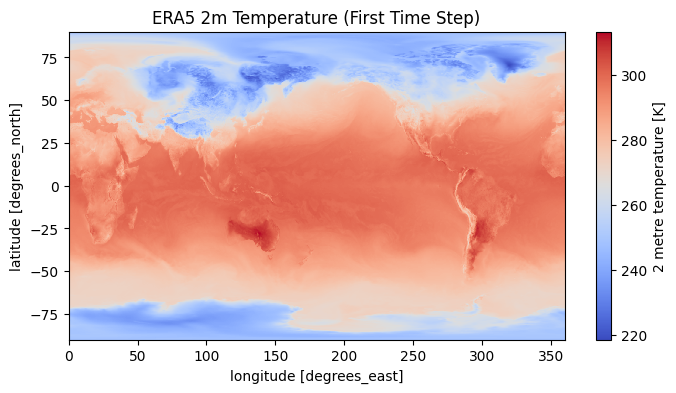

In [58]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset("era5_sample.nc")
print(ds)

t2m = ds['t2m']
print("Shape:", t2m.shape)

# correct dimension name: valid_time
t2m.isel(valid_time=0).plot(figsize=(8,4), cmap='coolwarm')
plt.title("ERA5 2m Temperature (First Time Step)")
plt.show()

In [60]:
!mkdir -p /content/drive/MyDrive/climate-gnn/data
!cp -v era5_sample.nc /content/drive/MyDrive/climate-gnn/data/

'era5_sample.nc' -> '/content/drive/MyDrive/climate-gnn/data/era5_sample.nc'


In [61]:
import numpy as np
lats = ds['latitude'].values
lons = ds['longitude'].values
print("lat len, lon len:", len(lats), len(lons))
lat_idx = slice(0, min(10, len(lats)))
lon_idx = slice(0, min(10, len(lons)))
sub_lats = lats[lat_idx]
sub_lons = lons[lon_idx]

nodes = []
for i,lat in enumerate(sub_lats):
    for j,lon in enumerate(sub_lons):
        nodes.append({"id": f"n_{i}_{j}", "lat": float(lat), "lon": float(lon)})

print("Created", len(nodes), "nodes (example):", nodes[:3])

lat len, lon len: 721 1440
Created 100 nodes (example): [{'id': 'n_0_0', 'lat': 90.0, 'lon': 0.0}, {'id': 'n_0_1', 'lat': 90.0, 'lon': 0.25}, {'id': 'n_0_2', 'lat': 90.0, 'lon': 0.5}]


In [63]:
!pip freeze > /content/drive/MyDrive/climate-gnn/requirements.txt
!echo "Saved requirements.txt to Drive: /content/drive/MyDrive/climate-gnn/requirements.txt"

Saved requirements.txt to Drive: /content/drive/MyDrive/climate-gnn/requirements.txt
